<a href="https://colab.research.google.com/github/adrianbarrenada/APRENDIZAJE_AUTOMATICO_23_24/blob/main/Untitled1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# prompt: open file train in the zip sentiment_analyisis

import zipfile

# Replace 'sentiment_analyisis.zip' with the actual filename if it's different
zip_file_path = '/content/sentiment_analysis.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Print the list of files in the zip archive to verify 'train' exists
    print(zip_ref.namelist())

    # Open the 'train' file (assuming it's a text file)
    try:
      with zip_ref.open('train.csv') as train_file:
          # Process the contents of the 'train' file here
          # For example, to read it line by line:
          for line in train_file:
              print(line)
    except KeyError:
        print("Error: 'train' file not found in the zip archive.")



['train.csv', '__MACOSX/._train.csv', 'test.csv', '__MACOSX/._test.csv']
b'textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km\xb2),Density (P/Km\xb2)\r\n'
b'cb774db0d1," I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860,60\r\n'
b'549e992a42, Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400,105\r\n'
b'088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740,18\r\n'
b'9642c003ef, what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470,164\r\n'
b'358bd9e861," Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700,26\r\n'
b'28b57f3990,http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth,http://www.dothebouncy.com/smf - some shameless 

In [2]:
import zipfile
import pandas as pd

zip_file_path = '/content/sentiment_analysis.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    with zip_ref.open('train.csv') as train_file:
        df = pd.read_csv(train_file, encoding='latin1')

print(df.head())


       textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment Time of Tweet Age of User  \
0  I`d have responded, if I were going   neutral       morning        0-20   
1                             Sooo SAD  negative          noon       21-30   
2                          bullying me  negative         night       31-45   
3                       leave me alone  negative       morning       46-60   
4                        Sons of ****,  negative          noon       60-70   

       Country  Population -2020  Land Area (Km²)  Density (P/Km²)  
0  Afghanistan          38928346         652860.0    

In [3]:
import re

def clean_text(text):
    text = str(text).lower()  # Minúsculas
    text = re.sub(r'[^a-z0-9\s]', '', text)  # Eliminar signos de puntuación
    text = re.sub(r'\s+', ' ', text).strip()  # Eliminar espacios extra
    return text

df['clean_text'] = df['text'].apply(clean_text)
df['clean_selected_text'] = df['selected_text'].apply(clean_text)


In [4]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['sentiment_label'] = le.fit_transform(df['sentiment'])


In [5]:
!pip install tensorflow

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_text'])

word2idx = tokenizer.word_index
idx2word = {i: w for w, i in word2idx.items()}
vocab_size = len(word2idx) + 1  # +1 por padding 0 si lo necesitas


In [7]:
from itertools import chain
import numpy as np

def generate_skipgram_pairs(texts, window_sizes=[2, 4]):
    pairs = []
    for text in texts:
        tokens = tokenizer.texts_to_sequences([text])[0]
        for i, center_word in enumerate(tokens):
            for w in window_sizes:
                for j in range(i - w, i + w + 1):
                    if i != j and 0 <= j < len(tokens):
                        context_word = tokens[j]
                        pairs.append((center_word, context_word))
    return pairs

skipgram_pairs = generate_skipgram_pairs(df['clean_text'], window_sizes=[2, 4])


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Reshape, Dense

def build_skipgram_model(vocab_size, embedding_dim):
    # Entrada central y de contexto
    center_input = Input(shape=(1,))
    context_input = Input(shape=(1,))

    # Capa de embeddings
    embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=1, name='embedding')

    center_emb = embedding(center_input)
    context_emb = embedding(context_input)

    # Producto punto y reshape
    dot_product = Dot(axes=-1)([center_emb, context_emb])
    dot_product = Reshape((1,))(dot_product)

    # Salida con activación sigmoide
    output = Dense(1, activation='sigmoid')(dot_product)

    model = Model(inputs=[center_input, context_input], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model


In [9]:
embedding_dim = 100  # Puedes hacerlo dinámico
model = build_skipgram_model(vocab_size, embedding_dim)
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 100)    │  2,908,600 │ input_layer[0][0… │
│ (Embedding)         │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1, 1)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1)         │          0 │ dot[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ reshape[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,908,602 (11.10 MB)

 Trainable params: 2,908,602 (11.10 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Entradas
center_words = np.array([cw for cw, _ in skipgram_pairs])
context_words = np.array([ctx for _, ctx in skipgram_pairs])

# Etiquetas positivas (pares reales)
labels = np.ones(len(center_words))


In [11]:
embedding_dims = [45, 312, 752]
histories = {}  # Guardamos las historias de entrenamiento
models = {}     # Guardamos los modelos entrenados


In [12]:
from tensorflow.keras.callbacks import History

for dim in embedding_dims:
    print(f"Entrenando modelo con embedding_dim={dim}")
    model = build_skipgram_model(vocab_size, dim)

    history = model.fit(
        x=[center_words, context_words],
        y=labels,
        epochs=10,  # puedes ajustar el número
        batch_size=1024,
        verbose=0
    )

    models[dim] = model
    histories[dim] = history


Entrenando modelo con embedding_dim=45
Entrenando modelo con embedding_dim=312
Entrenando modelo con embedding_dim=752


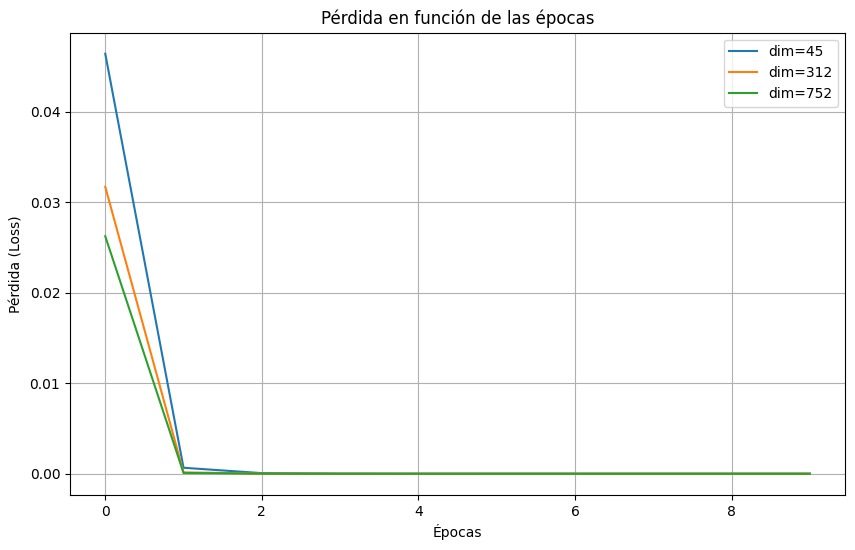

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for dim in embedding_dims:
    plt.plot(histories[dim].history['loss'], label=f"dim={dim}")
plt.xlabel("Épocas")
plt.ylabel("Pérdida (Loss)")
plt.title("Pérdida en función de las épocas")
plt.legend()
plt.grid(True)
plt.show()


In [14]:
from collections import Counter

# Extraemos todas las palabras
all_tokens = list(chain(*tokenizer.texts_to_sequences(df['clean_text'])))
top_tokens = Counter(all_tokens).most_common(10)

top_word_ids = [word_id for word_id, _ in top_tokens]
top_words = [idx2word[word_id] for word_id in top_word_ids]

print("Top 10 palabras más frecuentes:", top_words)


Top 10 palabras más frecuentes: ['i', 'to', 'the', 'a', 'my', 'and', 'you', 'it', 'is', 'in']


In [15]:
from sklearn.metrics.pairwise import cosine_distances
import numpy as np

def extract_embedding_matrix(model):
    return model.get_layer('embedding').get_weights()[0]


In [16]:
import pandas as pd

for dim in embedding_dims:
    print(f"\nComparando distancias para embedding_dim={dim}")
    embedding_matrix = extract_embedding_matrix(models[dim])
    vectors = np.array([embedding_matrix[word_id] for word_id in top_word_ids])

    distances = cosine_distances(vectors)
    df_dist = pd.DataFrame(distances, index=top_words, columns=top_words)
    display(df_dist.round(3))  # Redondeamos para mejor visualización



Comparando distancias para embedding_dim=45


i     to    the      a     my    and    you     it     is     in
i    0.000  0.003  0.003  0.004  0.004  0.004  0.006  0.004  0.005  0.005
to   0.003  0.000  0.002  0.003  0.003  0.004  0.006  0.005  0.006  0.004
the  0.003  0.002  0.000  0.002  0.002  0.002  0.004  0.003  0.004  0.003
a    0.004  0.003  0.002  0.000  0.002  0.002  0.002  0.002  0.003  0.002
my   0.004  0.003  0.002  0.002  0.000  0.003  0.003  0.003  0.003  0.003
and  0.004  0.004  0.002  0.002  0.003  0.000  0.003  0.002  0.003  0.003
you  0.006  0.006  0.004  0.002  0.003  0.003  0.000  0.002  0.002  0.001
it   0.004  0.005  0.003  0.002  0.003  0.002  0.002  0.000  0.002  0.002
is   0.005  0.006  0.004  0.003  0.003  0.003  0.002  0.002  0.000  0.002
in   0.005  0.004  0.003  0.002  0.003  0.003  0.001  0.002  0.002  0.000


Comparando distancias para embedding_dim=312


i     to    the      a     my    and    you     it     is     in
i    0.000  0.015  0.022  0.016  0.020  0.015  0.014  0.015  0.022  0.023
to   0.015  0.000  0.018  0.019  0.018  0.018  0.017  0.018  0.020  0.022
the  0.022  0.018  0.000  0.017  0.016  0.016  0.021  0.019  0.016  0.012
a    0.016  0.019  0.017  0.000  0.017  0.014  0.020  0.019  0.015  0.015
my   0.020  0.018  0.016  0.017  0.000  0.014  0.021  0.017  0.011  0.017
and  0.015  0.018  0.016  0.014  0.014  0.000  0.017  0.014  0.012  0.017
you  0.014  0.017  0.021  0.020  0.021  0.017  0.000  0.017  0.020  0.022
it   0.015  0.018  0.019  0.019  0.017  0.014  0.017  0.000  0.014  0.021
is   0.022  0.020  0.016  0.015  0.011  0.012  0.020  0.014  0.000  0.015
in   0.023  0.022  0.012  0.015  0.017  0.017  0.022  0.021  0.015  0.000


Comparando distancias para embedding_dim=752


i     to    the      a     my    and    you     it     is     in
i    0.000  0.036  0.044  0.042  0.043  0.038  0.034  0.034  0.046  0.049
to   0.036  0.000  0.030  0.032  0.036  0.034  0.033  0.038  0.039  0.035
the  0.044  0.030  0.000  0.036  0.035  0.028  0.042  0.040  0.030  0.021
a    0.042  0.032  0.036  0.000  0.040  0.029  0.035  0.038  0.032  0.035
my   0.043  0.036  0.035  0.040  0.000  0.031  0.042  0.042  0.034  0.036
and  0.038  0.034  0.028  0.029  0.031  0.000  0.036  0.028  0.032  0.029
you  0.034  0.033  0.042  0.035  0.042  0.036  0.000  0.040  0.044  0.043
it   0.034  0.038  0.040  0.038  0.042  0.028  0.040  0.000  0.035  0.042
is   0.046  0.039  0.030  0.032  0.034  0.032  0.044  0.035  0.000  0.037
in   0.049  0.035  0.021  0.035  0.036  0.029  0.043  0.042  0.037  0.000

In [17]:
# Mostrar los pares más similares (distancia más baja)
for dim in embedding_dims:
    print(f"\nPares más similares para embedding_dim={dim}:")
    embedding_matrix = extract_embedding_matrix(models[dim])
    vectors = np.array([embedding_matrix[word_id] for word_id in top_word_ids])
    distances = cosine_distances(vectors)

    pairs = []
    for i in range(len(top_words)):
        for j in range(i+1, len(top_words)):
            pairs.append((top_words[i], top_words[j], distances[i][j]))

    sorted_pairs = sorted(pairs, key=lambda x: x[2])
    for p in sorted_pairs[:3]:
        print(f"{p[0]} - {p[1]} → distancia coseno: {p[2]:.4f}")



Pares más similares para embedding_dim=45:
you - in → distancia coseno: 0.0010
a - in → distancia coseno: 0.0018
a - and → distancia coseno: 0.0018

Pares más similares para embedding_dim=312:
my - is → distancia coseno: 0.0109
the - in → distancia coseno: 0.0120
and - is → distancia coseno: 0.0120

Pares más similares para embedding_dim=752:
the - in → distancia coseno: 0.0209
the - and → distancia coseno: 0.0277
and - it → distancia coseno: 0.0280
